# Showcase Peony Project

### Import Peony Packages

In [1]:
from PeonyPackage.PeonyDb import MongoDb
from Peony_visualization.src.peony_visualization import calculate_binary_metrics
from Peony_box.src.peony_box_model import PeonyBoxModel
from Peony_box.src.peony_adjusted_models.random_trees_model import PeonyRandomForest
from Peony_box.src.transformators.HuffPost_transformator import HuffPostTransform as transformator
from Peony_database.src.datasets.HuffPost_news_dataset import (
    COLLECTION_NAME as HuffPost_collection_name,
    COLLECTION_ID as HuffPost_collection_id,
)
from Peony_box.src.utils import k_fold_corss_validation, auc_metrics
from Peony_box.src.acquisition_functions.functions import entropy_sampling

### Import Other Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.utils import io
from tqdm import tqdm_notebook as tqdm

from scipy.sparse import vstack
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## Create Peony Databse API

In [3]:
api = MongoDb()

## Get articles and labebls from Peony Databse

In [4]:
sport_records = api.get_record(
    collection_name=HuffPost_collection_name,
    collection_id=HuffPost_collection_id,
    label="SPORTS",
    limit=500,
)

comedy_records = api.get_record(
    collection_name=HuffPost_collection_name,
    collection_id=HuffPost_collection_id,
    label="COMEDY",
    limit=500,
)

instances = sport_records + comedy_records
labels = [sample["record"]["label"] for sample in sport_records + comedy_records]

instances, labels = shuffle(instances, labels, random_state=0)
HuffPostTransform = transformator()
_ = HuffPostTransform.transform_instances(instances)

100%|██████████| 1000/1000 [00:00<00:00, 184227.35it/s]


## K-Fold Cross Validation and Visualization

### Random Forest K-Fold Cross Validation

In [5]:
peony_model = PeonyBoxModel(HuffPostTransform)
k_fold = k_fold_corss_validation(
        peony_model.random_forest_model, HuffPostTransform, instances, labels, 10
    )

100%|██████████| 1000/1000 [00:00<00:00, 315931.30it/s]

transforming instances for k fold cross validation...



  0%|          | 0/10 [00:00<?, ?it/s]

transforming labels for k fold cross validation...
k fold cross validation...


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


### Random Forest Results

Label 11 in mapped to 0, label 12 in mapped to 1


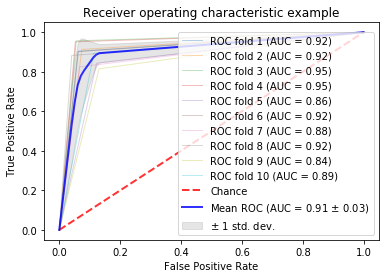

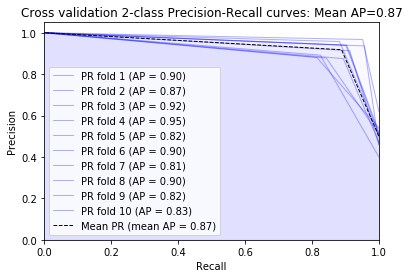

In [6]:
calculate_binary_metrics(k_fold)

### SVM K-Fold Cross Validation

In [7]:
peony_model = PeonyBoxModel(HuffPostTransform)
k_fold = k_fold_corss_validation(
        peony_model.svm_model, HuffPostTransform, instances, labels, 10
    )

100%|██████████| 1000/1000 [00:00<00:00, 332222.10it/s]

transforming instances for k fold cross validation...



  0%|          | 0/10 [00:00<?, ?it/s]

transforming labels for k fold cross validation...
k fold cross validation...


100%|██████████| 10/10 [01:20<00:00,  8.05s/it]


### SVM Results

Label 11 in mapped to 0, label 12 in mapped to 1


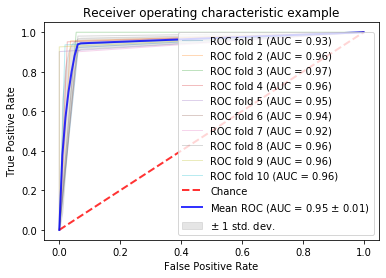

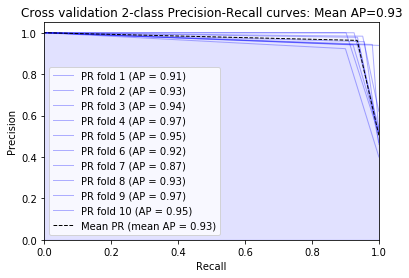

In [8]:
calculate_binary_metrics(k_fold)

### Feed Forward NN K-Fold Cross Validation

In [9]:
peony_model = PeonyBoxModel(HuffPostTransform)
k_fold = k_fold_corss_validation(
        peony_model.feed_forward_nn, HuffPostTransform, instances, labels, 10
    )

100%|██████████| 1000/1000 [00:00<00:00, 309702.72it/s]

transforming instances for k fold cross validation...



  0%|          | 0/10 [00:00<?, ?it/s]

transforming labels for k fold cross validation...
k fold cross validation...


100%|██████████| 10/10 [48:04<00:00, 288.44s/it]

starting loss (ensembles mean) is 3.7111337184906006 , fitted loss (ensembles mean) is 2.7654571533203125
starting loss (ensembles mean) is 3.7200331687927246 , fitted loss (ensembles mean) is 2.763441801071167
starting loss (ensembles mean) is 3.7131471633911133 , fitted loss (ensembles mean) is 2.763343095779419
starting loss (ensembles mean) is 3.7157514095306396 , fitted loss (ensembles mean) is 2.7628989219665527
starting loss (ensembles mean) is 3.7143869400024414 , fitted loss (ensembles mean) is 2.761833429336548
starting loss (ensembles mean) is 3.7162363529205322 , fitted loss (ensembles mean) is 2.7616372108459473
starting loss (ensembles mean) is 3.716156244277954 , fitted loss (ensembles mean) is 2.7636618614196777
starting loss (ensembles mean) is 3.7229931354522705 , fitted loss (ensembles mean) is 2.761596202850342
starting loss (ensembles mean) is 3.718470335006714 , fitted loss (ensembles mean) is 2.7615511417388916
starting loss (ensembles mean) is 3.7194292545318604

### Feed Forward NN Results

Label 11 in mapped to 0, label 12 in mapped to 1


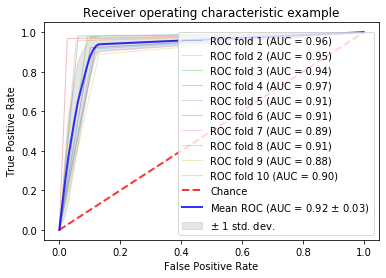

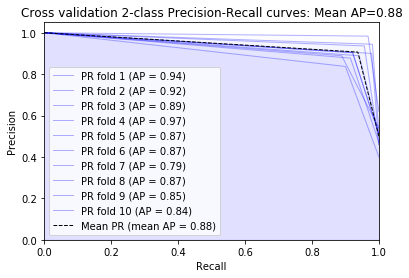

In [10]:
calculate_binary_metrics(k_fold)

## Active Learning Utils

### Initialize model -> Fit model -> Retrain model with extended training dataset

### Random Forest

In [9]:
#Initialize and fit model
peony_model = PeonyBoxModel(HuffPostTransform, active_learning_step=5)
peony_model.random_forest_model.fit(instances[100:], labels[100:])

#Get new training samples indices (random training samples indices)
indices = peony_model.random_forest_model.get_learning_samples(instances[:50])

additional_instances = [instances[index] for index in indices.tolist()]
additional_labels = [labels[index] for index in indices.tolist()]

#Retrain the model with new extended training dataset
peony_model.random_forest_model.add_new_learning_samples(additional_instances, additional_labels)

100%|██████████| 900/900 [00:00<00:00, 238780.04it/s]

transforming instances for model training...



100%|██████████| 900/900 [00:00<00:00, 1549619.70it/s]

transforming labels for model training...



100%|██████████| 5/5 [00:00<00:00, 35665.85it/s]

transforming instances for model getting learning sample...
transforming instances for model training...
transforming labels for model training...


### SVM

In [11]:
#Initialize and fit model
peony_model = PeonyBoxModel(HuffPostTransform, active_learning_step=5)
peony_model.svm_model.fit(instances[100:], labels[100:])

#Get new training samples indices (random training samples indices)
indices = peony_model.svm_model.get_learning_samples(instances[:50])

additional_instances = [instances[index] for index in indices.tolist()]
additional_labels = [labels[index] for index in indices.tolist()]

#Retrain the model with new extended training dataset
peony_model.svm_model.add_new_learning_samples(additional_instances, additional_labels)

100%|██████████| 900/900 [00:00<00:00, 315889.00it/s]

transforming instances for model training...



100%|██████████| 900/900 [00:00<00:00, 1645542.11it/s]

transforming labels for model training...



100%|██████████| 50/50 [00:00<00:00, 249067.93it/s]

transforming instances for model getting learning sample...



100%|██████████| 5/5 [00:00<00:00, 17476.27it/s]

transforming instances for model training...
transforming labels for model training...


### Feed Forward NN

In [ ]:
#Initialize and fit model
peony_model = PeonyBoxModel(HuffPostTransform, active_learning_step=5)
peony_model.feed_forward_nn.fit(instances[100:], labels[100:])

#Get new training samples indices (random training samples indices)
indices = peony_model.feed_forward_nn.get_learning_samples(instances[:50])

additional_instances = [instances[index] for index in indices.tolist()]
additional_labels = [labels[index] for index in indices.tolist()]

#Retrain the model with new extended training dataset
peony_model.feed_forward_nn.add_new_learning_samples(additional_instances, additional_labels)

100%|██████████| 900/900 [00:00<00:00, 261853.05it/s]

transforming instances for model training...



100%|██████████| 900/900 [00:00<00:00, 1641963.29it/s]

transforming labels for model training...



100%|██████████| 50/50 [00:00<00:00, 79107.96it/s]

transforming instances for model getting learning sample...



100%|██████████| 5/5 [00:00<00:00, 7063.50it/s]

transforming instances for model training...
transforming labels for model training...


## Active Learning Performance

In [5]:
def reset_validation_data(testing_instances, 
                          testing_labels, 
                          new_training_indices):
    new_training_indices = new_training_indices.tolist()
    training_instances = [testing_instances[index] for index in new_training_indices]
    training_labels = [testing_labels[index] for index in new_training_indices]
    testing_instances = np.delete(testing_instances, new_training_indices, axis=0)
    testing_labels = np.delete(testing_labels, new_training_indices, axis=None)

    return training_instances, training_labels, testing_instances, testing_labels
    

### Random Forest Active Learning (Entropy vs Random Sampling)

### Active Learning Pipeline

#### Random Training Data Sampling

In [6]:
auc_active_learning_random_10_runs = []
for _ in tqdm(range(5)):
    #Data preparation
    max_active_learning_iters = 100
    active_learning_step = 5
    auc_active_learning_random = []

    training_instances = instances[:10]
    training_labels = labels[:10]

    testing_instances = instances[10:]
    testing_labels = labels[10:]

    #Active Learning Pipeline Run
    peony_model = PeonyBoxModel(HuffPostTransform, active_learning_step=active_learning_step)
    with io.capture_output() as captured: #suppressing output
        peony_model.random_forest_model.fit(training_instances, training_labels);
    for index in (range(max_active_learning_iters)):
        with io.capture_output() as captured: #suppressing output
            predicted = peony_model.random_forest_model.predict(testing_instances);

            labels_for_auc = HuffPostTransform.transform_labels(testing_labels);
            auc_active_learning_random.append(auc_metrics([{"true": labels_for_auc, "predicted": predicted}]))

            indices = peony_model.random_forest_model.get_learning_samples(testing_instances)
            training_instances, training_labels, testing_instances, testing_labels = reset_validation_data(testing_instances, testing_labels, indices)
            peony_model.random_forest_model.add_new_learning_samples(training_instances, training_labels);
    auc_active_learning_random_10_runs.append(auc_active_learning_random)

#### Entropy Training Data Sampling

In [7]:
auc_active_learning_entropy_10_runs = []
for _ in tqdm(range(5)):
    #Data preparation
    max_active_learning_iters = 100
    active_learning_step = 5
    auc_active_learning_entropy = []

    training_instances = instances[:10]
    training_labels = labels[:10]

    testing_instances = instances[10:]
    testing_labels = labels[10:]

    #Active Learning Pipeline Run
    peony_model = PeonyBoxModel(HuffPostTransform, active_learning_step=active_learning_step, acquisition_function=entropy_sampling)
    with io.capture_output() as captured: #suppressing output
        peony_model.random_forest_model.fit(training_instances, training_labels)
    for index in (range(max_active_learning_iters)):
        with io.capture_output() as captured: #suppressing output
            predicted = peony_model.random_forest_model.predict(testing_instances)

            labels_for_auc = HuffPostTransform.transform_labels(testing_labels)
            auc_active_learning_entropy.append(auc_metrics([{"true": labels_for_auc, "predicted": predicted}]))

            indices = peony_model.random_forest_model.get_learning_samples(testing_instances)
            training_instances, training_labels, testing_instances, testing_labels = reset_validation_data(testing_instances, testing_labels, indices)
            peony_model.random_forest_model.add_new_learning_samples(training_instances, training_labels)
    auc_active_learning_entropy_10_runs.append(auc_active_learning_entropy)

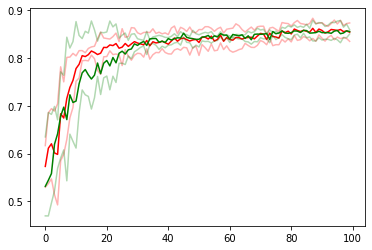

In [8]:
plt.plot(np.mean(auc_active_learning_random_10_runs, axis = 0), color="r")
plt.plot(np.mean(auc_active_learning_random_10_runs, axis = 0)+ np.std(auc_active_learning_random_10_runs, axis = 0), color="r", alpha=0.3)
plt.plot(np.mean(auc_active_learning_random_10_runs, axis = 0)- np.std(auc_active_learning_random_10_runs, axis = 0), color="r", alpha=0.3)

plt.plot(np.mean(auc_active_learning_entropy_10_runs, axis = 0), color="g")
plt.plot(np.mean(auc_active_learning_random_10_runs, axis = 0)+ np.std(auc_active_learning_entropy_10_runs, axis = 0), color="g", alpha=0.3)
plt.plot(np.mean(auc_active_learning_entropy_10_runs, axis = 0)- np.std(auc_active_learning_entropy_10_runs, axis = 0), color="g", alpha=0.3,)